# Malaria Image Detection
## Connor Mulshine

In [1]:
import pandas as pd
import numpy as np
import os
from imutils import paths
import random
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
folder_path = '/medical_image_analysis/cell_images
base_path = '/medical_image_analysis'

# Example: List files in the folder
import os

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    print(file_path)

/content/drive/MyDrive/medical_image_analysis/cell_images/.DS_Store
/content/drive/MyDrive/medical_image_analysis/cell_images/Parasitized
/content/drive/MyDrive/medical_image_analysis/cell_images/Uninfected


In [ ]:
# Grab the paths to all input images in the original input directory and shuffle them
imagePaths = list(paths.list_images(folder_path))
random.seed(42)
random.shuffle(imagePaths)

# Compute the training and testing split
train_split = 0.8
val_split = 0.1

i = int(len(imagePaths) * train_split)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# Use part of the training data for validation
i = int(len(trainPaths) * val_split)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# Derive the training, validation, and testing directories
train_path = os.path.sep.join([base_path, "training"])
val_path = os.path.sep.join([base_path, "validation"])
test_path = os.path.sep.join([base_path, "testing"])

# Define the datasets that we'll be building
datasets = [
    ("training", trainPaths, train_path),
    ("validation", valPaths, val_path),
    ("testing", testPaths, test_path)]

# Loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:

    # Show which data split we are creating
    print("[INFO] building '{}' split".format(dType))

    # If the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)

    # Loop over the input image paths
    for inputPath in imagePaths:

        # Extract the filename of the input image along with its corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]

        # Build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])

        # If the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)

        # Construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

In [5]:
# determine the total number of image paths in training, validation, and testing directories
totalTrain = len(list(paths.list_images(train_path)))
totalVal = len(list(paths.list_images(val_path)))
totalTest = len(list(paths.list_images(test_path)))

In [6]:
# Design CNN using keras, using pretrained network VGG16
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape=(48, 48, 3))

# Create a new model with the VGG16 base for feature extraction
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid')) # Output layer

# Freeze the layers of the VGG19 base, since they are already trained
for layer in conv_base.layers:
    layer.trainable = False

# Compile model with loss function, optimizer, & evaluation metric defined
init_lr = 1e-3
opt = SGD(learning_rate=init_lr, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Display the model summary
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14731137 (56.19 MB)
Trainable params: 16449 (64.25 KB)
Non-trainable params: 14714688 (56.13 MB)
____________

In [7]:
# Define the total number of epochs to train for along with the initial learning rate and batch size
n_epochs = 25
BS = 25

def poly_decay(epoch):
    # Initialize the maximum number of epochs, base learning rate, and power of the polynomial
    maxEpochs = n_epochs
    baseLR = init_lr
    power = 1.0
    # Compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    # Return the new learning rate
    return alpha

In [8]:
# Initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

# Initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [9]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
    train_path,
    class_mode="binary",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=True,
    batch_size=BS)

# Initialize the validation generator
valGen = valAug.flow_from_directory(
    val_path,
    class_mode="binary",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

# Initialize the testing generator
testGen = valAug.flow_from_directory(
    test_path,
    class_mode="binary",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [62]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint("model_weights_2.h5", save_weights_only=True, save_best_only=True)

# Define our set of callbacks and fit the model
callbacks = [LearningRateScheduler(poly_decay), checkpoint_callback]

H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BS,
    validation_data=valGen,
    validation_steps=totalVal // BS,
    epochs=n_epochs,
    callbacks=callbacks)

Epoch 1/25
793/793 [==============================] - 3245s 4s/step - loss: 0.5079 - accuracy: 0.7558 - val_loss: 0.3897 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 2/25
793/793 [==============================] - 610s 770ms/step - loss: 0.3972 - accuracy: 0.8267 - val_loss: 0.3457 - val_accuracy: 0.8591 - lr: 9.6000e-04
Epoch 3/25
793/793 [==============================] - 579s 730ms/step - loss: 0.3629 - accuracy: 0.8428 - val_loss: 0.3186 - val_accuracy: 0.8673 - lr: 9.2000e-04
Epoch 4/25
793/793 [==============================] - 602s 759ms/step - loss: 0.3462 - accuracy: 0.8537 - val_loss: 0.3156 - val_accuracy: 0.8727 - lr: 8.8000e-04
Epoch 5/25
793/793 [==============================] - 580s 731ms/step - loss: 0.3323 - accuracy: 0.8568 - val_loss: 0.3005 - val_accuracy: 0.8818 - lr: 8.4000e-04
Epoch 6/25
793/793 [==============================] - 605s 763ms/step - loss: 0.3277 - accuracy: 0.8631 - val_loss: 0.2949 - val_accuracy: 0.8855 - lr: 8.0000e-04
Epoch 7/25
793/793 [========

In [15]:
# Reset the testing generator and then use our trained model to make predictions on the data
testGen.reset()
predIdxs, test_accuracy = model.evaluate(x=testGen, steps=(totalTest // BS) + 1)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

221/221 [==============================] - 141s 637ms/step - loss: 0.2752 - accuracy: 0.8826
Test Accuracy: 88.26%


In [16]:
# Extract features using the predict method
train_features = model.predict(trainGen, steps=len(trainGen), verbose=1)
np.save('train_features', train_features)
train_features = np.load('train_features.npy')

794/794 [==============================] - 518s 652ms/step


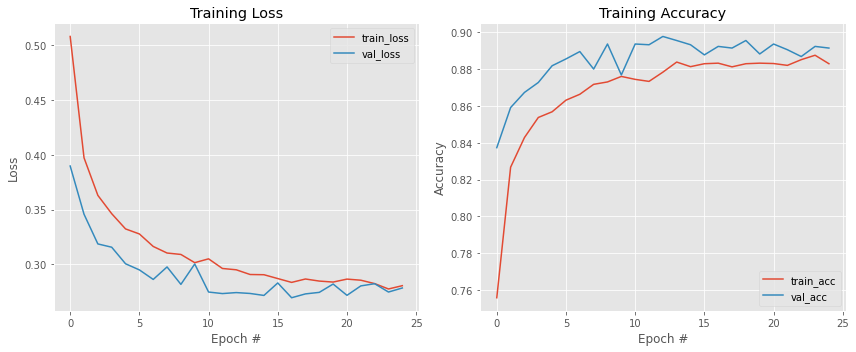

In [76]:
# Plot the training loss and accuracy
N = n_epochs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training accuracy
axes[0].plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
axes[0].plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
axes[0].set_title("Training Accuracy")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="lower right")

# Plot training loss
axes[1].plot(np.arange(0, N), H.history["loss"], label="train_loss")
axes[1].plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Loss")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()